In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pept import LineData, Pipeline, PointData
from pept.tracking import Stack, HDBSCAN, Cutpoints, SplitLabels, Centroids, Condition
from scipy.interpolate import interp1d
from skopt import gp_minimize
from skopt.space import Real, Integer
import sys
sys.path.append("/home/rayhaan/randomWalk_V3/Scripts/")
from interpolateTime import interpolateUnique
from tqdm import tqdm
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
%matplotlib widget

In [2]:
def errorCalculation(truePath: PointData, trackedPath: PointData) -> np.float64:
    fx = interp1d(truePath['t'], truePath['x'], fill_value = "extrapolate")
    fy = interp1d(truePath['t'], truePath['y'], fill_value = "extrapolate")
    fz = interp1d(truePath['t'], truePath['z'], fill_value = "extrapolate")

    xInterp = fx(trackedPath['t'])
    yInterp = fy(trackedPath['t'])
    zInterp = fz(trackedPath['t'])

    errorX = np.sum(np.abs(xInterp - trackedPath['x']))/len(xInterp)
    errorY = np.sum(np.abs(yInterp - trackedPath['y']))/len(xInterp)
    errorZ = np.sum(np.abs(zInterp - trackedPath['z']))/len(xInterp)

    combinedError = np.sqrt(errorX**2 + errorY**2 + errorZ**2)

    return combinedError

In [3]:
def loadTruePath(path: str) -> PointData:
    data = np.loadtxt(path, skiprows = 3)
    points = np.array([data[:, 0], data[:, 5], data[:, 6], data[:, 7]]).T
    pData = PointData(points)
    return pData

def loadData(path: str) -> LineData:
    lines = np.load(path)
    rawLines = np.array([lines[:, 6], lines[:, 0], lines[:, 1], lines[:, 2], lines[:, 3], lines[:, 4], lines[:, 5]]).T
    lData = LineData(rawLines)
    return lData

In [108]:
trueData = loadTruePath(path = "/home/rayhaan/randomWalk_V3/GATE_Generation/Sigma_0.1mm_Varying_Tau_0.08_1.20ms/Placements/RW3_TS_1.20ms_SS_0.10mm.placements")
lors = loadData(path = "/home/rayhaan/randomWalk_V3/GATE_Generation/Sigma_0.1mm_Varying_Tau_0.08_1.20ms/Lines_NPY/RW3_TS_1.20ms_SS_0.10mm.npy")

In [109]:
times = lors['t']
newTime = interpolateUnique(msTime = times)
lors_2 = LineData(np.c_[newTime, lors.lines[:, 1:7]])

In [112]:
MLPipe = Pipeline([
            Stack(sample_size = 375, overlap = 0),
            Cutpoints(max_distance = 3.0),
            HDBSCAN(true_fraction = 0.1),
            SplitLabels() + Centroids(),

            Stack(sample_size = 5, overlap = 4), 
            HDBSCAN(true_fraction = 0.6),
            SplitLabels() + Centroids(),
            Stack()
        ])

In [113]:
locTest = MLPipe.fit(lors_2)
print("The location rate is {} Hz".format(len(locTest.points)/0.5))

Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 443/443 [00:00<00:00, 8432.08it/s]



Processed samples in 35.68342661857605 s

The location rate is 802.0 Hz


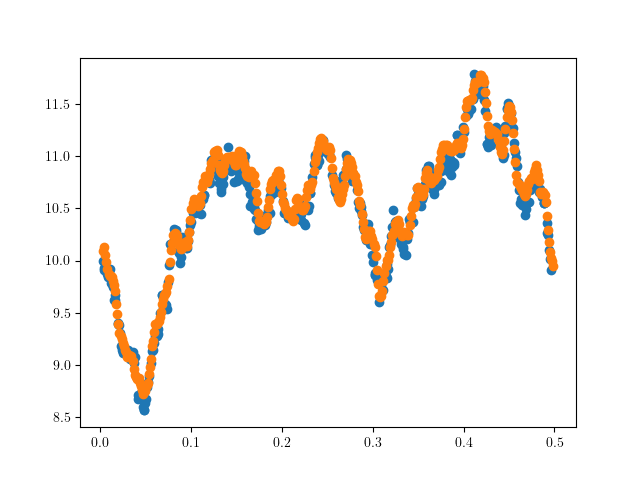

In [114]:
plt.close("all")
fig, ax = plt.subplots(1, 1)
ax.scatter(locTest['t'], locTest['x'])
ax.scatter(trueData['t'], trueData['x'])



In [33]:
# filter2 = Condition("t >= 0.0, t <= 0.5") + Stack()
# locTest2 = filter2.fit(locTest)a

In [59]:
# np.save("/home/rayhaan/randomWalk_V3/Plots/truePath", arr = trueData.points)

In [390]:
# plt.close("all")
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (7, 5), sharex = "col")

# fig.suptitle("TS_0.4ms_Lambda_2.0mm_L_245.954kHz")
# ax1.scatter(locTest2['t'], locTest2['x'], s = 0.1, color = 'k', zorder = 1, label = "ML_Track")
# ax1.plot(trueData['t'], trueData['x'], lw = 1, color = 'r', zorder = 0, label = "True_Path")

# ax2.scatter(locTest2['t'], locTest2['y'], s = 0.1, color = 'k', zorder = 1, label = "ML_Track")
# ax2.plot(trueData['t'], trueData['y'], lw = 1, color = 'r', zorder = 0, label = "True_Path")

# ax3.scatter(locTest2['t'], locTest2['z'], s = 0.1, color = 'k', zorder = 1, label = "ML_Track")
# ax3.plot(trueData['t'], trueData['z'], lw = 1, color = 'r', zorder = 0, label = "True_Path")

# ax1.legend()
# ax2.legend()
# ax3.legend()

# ax3.set_xlabel("t (s)")

# ax1.set_ylabel("X (mm)")
# ax2.set_ylabel("Y (mm)")
# ax3.set_ylabel("Z (mm)")

# fig.tight_layout()
# fig.savefig("/home/rayhaan/randomWalk_V3/Plots/Test_Extreme_OL1.png", dpi = 300)




In [115]:
def optAllML(lowerLocRate, upperLocRate, Data, truePath):

    # out = []

# for i in tqdm(range(len(UsedSampleSizes)-1)):
    def ObjectiveML(x):
        MLPipe = Pipeline([
            Stack(sample_size = x[0], overlap = 0),
            Cutpoints(max_distance = 3.0),
            HDBSCAN(true_fraction = x[1]),
            SplitLabels() + Centroids(),

            Stack(sample_size = 5, overlap = 4), 
            HDBSCAN(true_fraction = x[2]),
            SplitLabels() + Centroids(),
            Stack()
        ])

        locs = MLPipe.fit(Data, verbose = True)

        locRate = len(locs.points)/0.5

        error = errorCalculation(truePath = truePath, trackedPath = locs)

        if (locRate >= lowerLocRate) and (locRate <= upperLocRate):
            error = error
        else:
            error = 10000 + error

        print("The error is: {} mm, the location rate is: {} kHz".format(error, locRate))

        return error

    space = [Integer(365, 385, name = 'SS1'),
            # Real(1.0, 3.0, name = 'MD'),
            Real(0.1, 0.6, name = 'TF1'),
            Real(0.55, 0.65, name = 'TF2'),
                    ]

    res = gp_minimize(ObjectiveML, space, n_calls = 20, verbose = True, random_state = 657333)

    out1 = [res.fun, res.x[0], res.x[1], res.x[2]]

    return out1

In [116]:
1/(1.20e-3)

833.3333333333334

In [117]:
lowerLocRate = 750
upperLocRate = 950


In [118]:
optVals = optAllML(lowerLocRate = lowerLocRate, upperLocRate = upperLocRate, Data = lors_2, truePath = trueData)

Iteration No: 1 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 451/451 [00:00<00:00, 2178.12it/s]



Processed samples in 66.43397569656372 s

The error is: 0.13676903693193662 mm, the location rate is: 862.0 kHz
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 66.4365
Function value obtained: 0.1368
Current minimum: 0.1368
Iteration No: 2 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 6472.19it/s]



Processed samples in 263.7721710205078 s

The error is: 10000.138777908358 mm, the location rate is: 564.0 kHz
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 263.7748
Function value obtained: 10000.1388
Current minimum: 0.1368
Iteration No: 3 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 441/441 [00:00<00:00, 6254.12it/s]



Processed samples in 39.641855239868164 s

The error is: 10000.167200461468 mm, the location rate is: 100.0 kHz
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 39.6443
Function value obtained: 10000.1672
Current minimum: 0.1368
Iteration No: 4 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 431/431 [00:00<00:00, 6621.99it/s]



Processed samples in 35.53523278236389 s

The error is: 10000.168071825618 mm, the location rate is: 114.0 kHz
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 35.5377
Function value obtained: 10000.1681
Current minimum: 0.1368
Iteration No: 5 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 440/440 [00:00<00:00, 8101.63it/s]



Processed samples in 220.94444608688354 s

The error is: 10000.175261863049 mm, the location rate is: 90.0 kHz
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 220.9472
Function value obtained: 10000.1753
Current minimum: 0.1368
Iteration No: 6 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 451/451 [00:00<00:00, 1798.70it/s]



Processed samples in 44.765862464904785 s

The error is: 10000.171858455898 mm, the location rate is: 84.0 kHz
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 44.7688
Function value obtained: 10000.1719
Current minimum: 0.1368
Iteration No: 7 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 451/451 [00:00<00:00, 1844.99it/s]



Processed samples in 156.3589220046997 s

The error is: 0.14390517782249668 mm, the location rate is: 864.0 kHz
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 156.3617
Function value obtained: 0.1439
Current minimum: 0.1368
Iteration No: 8 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 431/431 [00:00<00:00, 8252.02it/s]



Processed samples in 234.1337468624115 s

The error is: 10000.170319051509 mm, the location rate is: 110.0 kHz
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 234.1358
Function value obtained: 10000.1703
Current minimum: 0.1368
Iteration No: 9 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:00<00:00, 8666.21it/s]



Processed samples in 241.98171162605286 s

The error is: 10000.361289852259 mm, the location rate is: 102.0 kHz
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 241.9837
Function value obtained: 10000.3613
Current minimum: 0.1368
Iteration No: 10 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 439/439 [00:00<00:00, 7391.16it/s]



Processed samples in 225.74932312965393 s

The error is: 10000.164444972323 mm, the location rate is: 110.0 kHz
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 226.1832
Function value obtained: 10000.1644
Current minimum: 0.1368
Iteration No: 11 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:00<00:00, 2258.54it/s]



Processed samples in 94.02507424354553 s

The error is: 0.14049284623516078 mm, the location rate is: 844.0 kHz
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 94.4885
Function value obtained: 0.1405
Current minimum: 0.1368
Iteration No: 12 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 447/447 [00:00<00:00, 8162.61it/s]



Processed samples in 67.52566242218018 s

The error is: 0.1360649891080093 mm, the location rate is: 846.0 kHz
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 67.9349
Function value obtained: 0.1361
Current minimum: 0.1361
Iteration No: 13 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 2104.71it/s]



Processed samples in 125.68040132522583 s

The error is: 0.16633757690202697 mm, the location rate is: 842.0 kHz
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 126.0566
Function value obtained: 0.1663
Current minimum: 0.1361
Iteration No: 14 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 446/446 [00:00<00:00, 8480.18it/s]



Processed samples in 151.26955819129944 s

The error is: 0.16986420404533278 mm, the location rate is: 840.0 kHz
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 151.7803
Function value obtained: 0.1699
Current minimum: 0.1361
Iteration No: 15 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 451/451 [00:00<00:00, 2305.32it/s]



Processed samples in 106.41454672813416 s

The error is: 10000.150473321642 mm, the location rate is: 84.0 kHz
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 106.8813
Function value obtained: 10000.1505
Current minimum: 0.1361
Iteration No: 16 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:00<00:00, 1539.31it/s]



Processed samples in 152.03001737594604 s

The error is: 0.13231572900679267 mm, the location rate is: 856.0 kHz
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 152.5955
Function value obtained: 0.1323
Current minimum: 0.1323
Iteration No: 17 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [00:00<00:00, 2348.17it/s]



Processed samples in 125.26649689674377 s

The error is: 0.16505697105505232 mm, the location rate is: 860.0 kHz
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 125.8470
Function value obtained: 0.1651
Current minimum: 0.1323
Iteration No: 18 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 6634.15it/s]



Processed samples in 153.22052526474 s

The error is: 0.14584282698151796 mm, the location rate is: 844.0 kHz
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 153.7759
Function value obtained: 0.1458
Current minimum: 0.1323
Iteration No: 19 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 452/452 [00:00<00:00, 2367.10it/s]



Processed samples in 152.29120779037476 s

The error is: 0.13699792731868626 mm, the location rate is: 854.0 kHz
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 152.9621
Function value obtained: 0.1370
Current minimum: 0.1323
Iteration No: 20 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 2352.12it/s]



Processed samples in 151.1395149230957 s

The error is: 0.13905300968691814 mm, the location rate is: 870.0 kHz
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 151.7941
Function value obtained: 0.1391
Current minimum: 0.1323


In [119]:
optVals

[0.13231572900679267, 370, 0.3858592171097214, 0.602015822795421]

In [120]:
MLPipeOpt = Pipeline([
            Stack(sample_size = optVals[1], overlap = 0),
            Cutpoints(max_distance = 3.0),
            HDBSCAN(true_fraction = optVals[2]),
            SplitLabels() + Centroids(),

            Stack(sample_size = 5, overlap = 4), 
            HDBSCAN(true_fraction = optVals[3]),
            SplitLabels() + Centroids(),
            Stack()
        ])

In [121]:
optLocs = MLPipeOpt.fit(lors_2)
print("The location rate is {:.2f} Hz".format(len(optLocs.points)/0.5))

Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 446/446 [00:00<00:00, 6630.25it/s]



Processed samples in 149.9475395679474 s

The location rate is 844.00 Hz


In [122]:
optLocs

pept.PointData (samples: 446)
-----------------------------
sample_size = [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
overlap = None
point

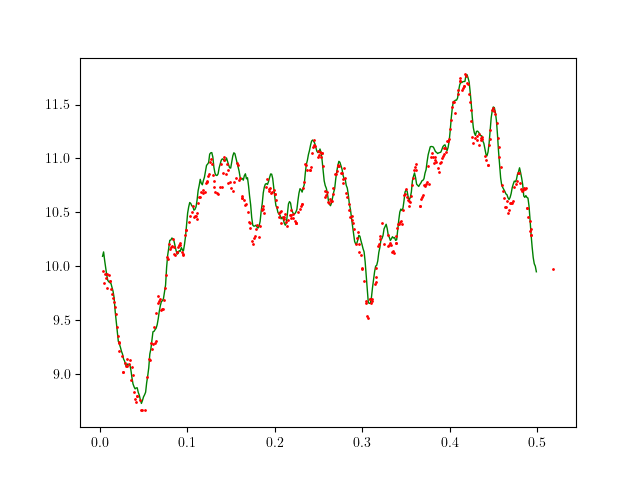

In [123]:
plt.close("all")
fig, ax = plt.subplots(1, 1)

ax.scatter(optLocs['t'], optLocs['x'], color = 'r', s = 1, zorder = 1)
ax.plot(trueData['t'], trueData['x'], color = 'g', lw = 1, zorder = 0)

In [124]:
filter1 = Condition("t >= 0.0, t <= 0.5") + Stack()
filteredLocs = filter1.fit(optLocs)

Batch 1 / 1 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 446/446 [00:00<00:00, 7646.11it/s]



Processed samples in 0.6127865314483643 s



In [125]:
np.save("/home/rayhaan/randomWalk_V3/GATE_Generation/Sigma_0.1mm_Varying_Tau_0.08_1.20ms/tracks/RW3_TS_1.20ms_SS_0.10mm", arr = filteredLocs.points)

In [126]:
uncertainty = errorCalculation(truePath = trueData, trackedPath = optLocs)

In [127]:
print("The uncertainty is {} mm".format(uncertainty))

The uncertainty is 0.13937360863084905 mm


In [129]:
optimVals_20 = np.loadtxt("/home/rayhaan/randomWalk_V3/Notebooks/opt_Sigma_2.0mm.csv", skiprows = 2, delimiter = ", ")
optimVals_01 = np.loadtxt("/home/rayhaan/randomWalk_V3/Notebooks/opt_Sigma_0.1mm.csv", skiprows = 2, delimiter = ", ")


In [130]:
taus = optimVals_01[:, 0]
dR_lambda_20 = optimVals_20[:, 4]
dR_lambda_01 = optimVals_01[:, 4]


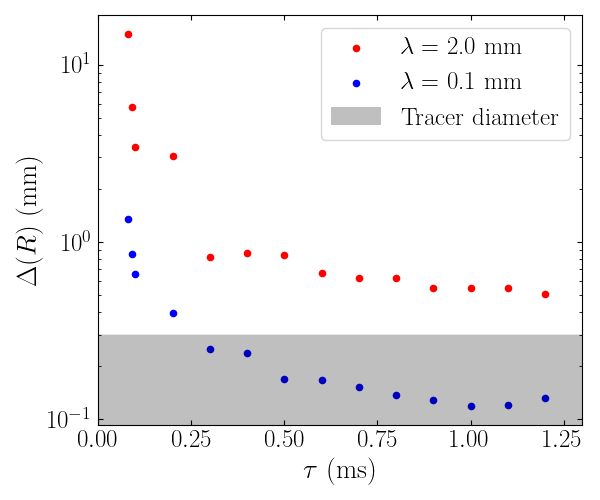

In [133]:
plt.close("all")
fig, ax = plt.subplots(1, 1, figsize = (6, 5))
s = 20


fillx = np.linspace(0.0, 1.3, 1000)
filly = np.repeat(0.3, len(fillx))

ax.scatter(taus, dR_lambda_20, s = 20, color = 'r', label = r"$\lambda$ = 2.0 mm")
ax.scatter(taus, dR_lambda_01, s = 20, color = 'b', label = r"$\lambda$ = 0.1 mm")
ax.fill_between(fillx, filly,  facecolor = 'k', alpha = 0.25, label = r"Tracer diameter", edgecolor = "None")

ax.set_xlabel(r"$\tau$ (ms)", fontsize = s)
ax.set_ylabel(r"$\Delta(R)$ (mm)", fontsize = s)

ax.get_xaxis().set_tick_params(direction = "in", which = "both", top = True)
ax.get_yaxis().set_tick_params(direction = "in", which = "both", right = True)

ax.legend(loc = "upper right", fontsize = s - 2)

ax.tick_params(axis="x", labelsize = s - 2) 
ax.tick_params(axis="y", labelsize = s - 2)
ax.set_yscale("log")

ax.set_xlim(0.0, 1.3)
# ax.set_ylim(0.0, 16)
fig.tight_layout()

fig.savefig("/home/rayhaan/randomWalk_V3/Plots/tau_deltaR_Lambda_0.1mm_2.0mm.png", dpi = 300)